# Description of processing steps
In the order that they are applied to the data.

In [1]:
%matplotlib inline
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

## Hame's preprocessed epochs
As far as I can remember and tell from her scripts, Hame has done the following pre-processing steps:

1. Maxwell filter (applied automatically by Neuromag to remove, e.g., motion artefacts)
2. high-pass filter with cut-off at 0.33 Hz
3. low-pass filter with cut-off at 45 Hz
4. downsample to 250 Hz (dt = 4 ms)
5. apply some kind of ICA-based pre-processing
6. extract epochs -300 ms to 900 ms around first dot onset time
7. apply some more artefact removal with ICA, but based on the whole data and then just 
   re-extract epochs; I think this step included some manual interventions
   
[According to MNE documentation](http://martinos.org/mne/stable/auto_tutorials/plot_background_filtering.html) there has been a recent debate in the EEG/MEG community about the suitability of bandpass filters and baseline correction. Specifically, it has been warned that [high-pass filter with cut-offs higher than 0.1 Hz may introduce unwanted effects](http://martinos.org/mne/stable/auto_tutorials/plot_background_filtering.html#id46), but [baseline correction may have problems on its own](http://martinos.org/mne/stable/auto_tutorials/plot_background_filtering.html#id47). Burkhard Maess apparently argued that baseline correction can be problematic, when there is consistent activation in the baseline period. Based on this discussion and the corresponding suggestions it may be best to use a high-pass filter with 0.1 Hz cut-off, or baseline correction.

## Pre-processing for GLM-analysis
I import Hame's preprocessed epochs into MNE and then apply the following MNE processing steps. 

When loading meta-info with MNE from the raw .fif-files that I got from Hame, it reports to have found PCA-based projections:
<pre>
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
</pre>
I'm not 100% sure what this is. It should be related to some [Signal-Space Projection (SSP) method](http://martinos.org/mne/stable/manual/preprocessing/ssp.html) and is most likely added by Elekta Neuromag's MaxFilter (see Temporal Subspace Projection in MaxFilter documentation?). Anyway, I switch the projection off when I process Hame's epochs, because I assume that it was already applied by Hame.

Steps:
1. select magnetometers only
2. resample to 100 Hz (dt = 10 ms)
3. crop the epoch to specified time window, e.g., 400 ms to 700 ms
4. smooth with Savitzky-Golay filter at 10 Hz
5. extract data from MNE epochs-container
6. normalise (subtract mean, divide by std) across all trials, subjects and time points, but within channels
7. remove trials for which the fitted model assigns very high probability (0.99) to the event that the subject has made their decision before the currently considered dot has been processed (removes 121 of 17280 trials for 5th dot)
8. remove trials in which the RT was below [onset time of the currently considered dot + 100 ms] assuming that the corresponding dot did not contribute to the decision in these trials (removes 145 of 17280 trials for 5th dot of which 9 trials were already excluded based on the previous point)

### Savitzky-Golay smoothing
[The Savitzky-Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) uses convolution to smooth discrete data. It's theoretically based on fitting polynomials of a given order to the local neighbourhood of a data point. It's parameters in the [scipy implementation](https://scipy.github.io/devdocs/generated/scipy.signal.savgol_filter.html) are the size of the local neighbourhood and the order of the polynomials. MNE uses this implementation but let's me provide a (low-pass) frequency to choose the size of the local neighbourhood. For my choice of data sampling rate of 100 Hz and Savitzky-Golay frequency of 10 Hz, the local neighbourhood consists of 11 data points. MNE chooses polynomials of 5th order and allows Savitzky-Golay frequencies of up to half the sampling rate. 

Here's the kernel that is convolved with the data for smoothing:

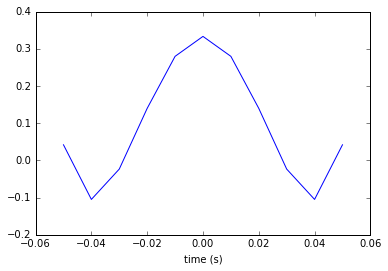

In [2]:
sfreq = 100
hfreq = 10
windowlength = (int(sfreq/hfreq) // 2) * 2 + 1
plt.plot((np.arange(windowlength) - np.floor(windowlength/2)) / sfreq, 
         scipy.signal.savgol_coeffs(windowlength, 5))
plt.xlabel('time (s)');

I tried my second-level analysis (summary statistics approach, 5th-dot regressors, 400-700 ms) with and without Savitzky Golay smoothing. Without the smoothing the smallest p-values within each time point (across channels) were a bit larger than with smoothing, but overall the effect of smoothing appears to be very small in this analysis.

## GLM (first-level)
For each subject I define a general linear model with

$$
y_{t, c, s} = X_{s}\beta_{t, c, s} + \epsilon_{t, c, s}
$$

where $y_{t, c, s}$ is the vector of pre-processed amplitudes of MEG channel $c$ at time $t$ across trials of subject $s$.

The regressors in the design matrix for each subject, $X_s$, are:
1. **dot_y**: the y-position of the chosen dot
2. **entropy**: the uncertainty associated with the response predicted by the model for the corresponding trial (equal across dots in that trial)
3. **intercept**: constant, a vector of ones
4. **logpost_left**: log-probability that the model assigns to the left response after seeing the chosen dot (and all before); strongly anti-correlated with the x-position of the corresponding dot, especially for late dots, and logpost_right; strongly correlated with the momentary evidence for the chosen dot for the left response
5. **surprise**: how surprising the chosen dot is for the model after having seen all previous dots; strongly anti-correlated with (log-)likelihoods of the dot under the generative models of the decision model which essentially means that dots are seldomly located in the interesting area between the two targets
6. **trial_time**: time in number of trials at which the subject saw the corresponding trial in the experiment

For the 5th dot, the correlation (or anti-correlation) of these regressors is below 0.3 except for the combination of logpost_left and entropy where there are 6 subjects for which the correlation between the two is in [0.3, 0.63].

### Normalisation of regressors and excluded subjects
I normalise (subtract mean, divide by std) all regressors (except for intercept) across all subjects and trials. This includes two subjects for which no MEG data is available, because (quote Hame):
> 14 had too many bad channels, and 30 had too many strong blink artifacts, 
> which was impossible to clean in any preprocessing.

### Inference
Each GLM is fitted to the data using ordinary least squares.

## Across-subject analysis (second-level)
### Summary statistic approach
I simply run a two-sided, one-sample t-test on the fitted parameter values $\beta_{t, c, s}$ across subjects for a single parameter. Specifically, this corresponds to running the t-test on the contrast $\zeta^T\beta$ where the contrast vector $\zeta$ is all 0 except for one 1.

I have verified that this approach is qualitatively equivalent to estimating population-level parameter values in a hierarchical Bayesian model with very wide priors. Specifically, this model is

$$\beta \sim N(0, 100)$$
$$\sigma \sim HalfCauchy(5)$$
$$\beta_s \sim N(\beta, \sigma)$$
$$\epsilon \sim HalfCauchy(5)$$
$$y_{t, c, s} \sim N(X_s\beta_s, \epsilon)$$

and I verified that the posterior over $\beta$ (Gaussian, estimated by ADVI) provides qualitatively equivalent 't-values' as the summary statistic approach.

I have not yet checked whether this simple model is suitable for describing the MEG data which amounts to checking whether residuals have approximately a Gaussian distribution, i.e., centred at 0 and no heavy tails.